### TMDB revenue forecasting contest

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import math
import random

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import ast
import warnings
import json

import itertools
from collections import Counter


from tqdm import tqdm

from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor

import xgboost as xgb

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split

# Any results you write to the current directory are saved as output.
%matplotlib inline
warnings.filterwarnings('ignore')

['test.csv', 'train.csv', 'sample_submission.csv']


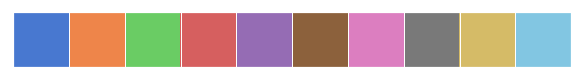

In [3]:
sns.set(style ='darkgrid')
sns.set(palette = 'muted')
col = sns.color_palette()
sns.palplot(col)

### Plot multiple Y axes for a common X axis

In [4]:
def plot_2y(df,x,y1,y2):
    fig,ax1 = plt.subplots(figsize = (15,10))
    ax1.plot(df[x],df[y1],'ro-')
    ax2 =ax1.twinx()
    ax2.plot(df[x], df[y2],'bo-')
    ax1.set_xlabel(x)
    ax1.set_ylabel(y1)
    ax2.set_ylabel(y2)
    if x == 'Month ':
        plt.title('Monthly delay incidents between '+ str(df['Month '].dt.year.min()) + ' and ' + str(df['Month '].dt.year.max()))
    else:
        plt.title(y1+' and '+ y2 +' vs '+ x)
    ax1.legend()
    ax2.legend(loc=1)
    plt.xticks(rotation = 45)
    plt.tight_layout()
    plt.show()

### Plot multiple scatter plots for the same independent variable

In [5]:
def plot_scatter(df,xdata,ydata1,ydata2=None,ydata3=None):
    plt.figure(figsize = (15,10))
    plt.scatter(df[xdata],df[ydata1],c='r')
    if pd.notna(ydata2):
        plt.scatter(df[xdata],df[ydata2],c='b')
        if pd.notna(ydata3):
            plt.scatter(df[xdata],df[ydata3],c='k')
    else:
        plt.ylabel(ydata1)
    plt.xlabel(xdata)
    plt.title(ydata1 + ' vs ' + xdata)
    plt.legend()
    plt.tight_layout()
    plt.show()

### Plot boxplots for boolean features

In [6]:
def booleanBoxPlot(df, bool_feature, other_feature, lang):
    """ Box plot of values of other_feature when bool_feature == True and 
    bool__feature == False"""
    
    fig = plt.figure(figsize=(15, 10))
    
    sns.boxplot(x = bool_feature, y = other_feature, data = df, whis=[10, 90], showfliers  = False)
    plt.xlabel(bool_feature)
    plt.ylabel(other_feature)
    
    title = other_feature + ' distributed by ' + bool_feature + ' for ' + lang
    plt.suptitle(title)

### Function to round up to the nearest integer that is larger than x

In [7]:
def roundup(x):
    return int(math.floor(x/10.0)) * 10

### Function to convert JSON fields into dictionaries

In [8]:
def json_to_dict(df, field):
     df.loc[df[field].notnull(), field] = df.loc[df[field].notnull(),field].apply(lambda x: x.lstrip('\"([').rstrip(']\")')).apply(eval) 

In [9]:
def get_json_dict(s):
    """ indirect way of converting json into python dictionary """
    try:
        d = eval(s)
    except:
        d = {}
    return d

In [10]:
def get_director(df):
    for index,row in df.iterrows():
        allCrew = get_json_dict(row['crew'])
        director = next((x['name'] for x in allCrew if ('name' in x) and ('job' in x) and (x['job'] == 'Director')),None)
        df.loc[index,'Director'] = director

In [11]:
def get_cast(df):
    for index,row in df.iterrows():
        allCast = get_json_dict(row['cast'])
        lead = next((x['name'] for x in allCast if ('name' in x)),None)
        df.loc[index,'Lead'] = lead

### Function to convert dictionary to a list of values in the dictionary

In [12]:
def dict_to_list(df, field):
    if field == 'genres':
        findex = 1
    else:
        findex = 0
    for index,row in df.loc[df[field].notna(),field].iteritems():
        if type(row) is dict:
            df.loc[index,field] = list(row.values())[findex]
        elif type(row) is tuple:
            field_list = []
            for i in np.arange(len(row)):
                field_list.append(list(row[i].values())[findex])
            df.at[index,field] = field_list

### Function to transform raw data - convert everything to log and perform one-hot encoding on selected features

In [13]:
def transform_ridge(df, top_languages = [], top_directors = [], top_cast = [], additional = 0, ohe_director = 0, ohe_cast = 0):

    df_copy = df.copy()
    df_copy['release_date'] = pd.to_datetime(df_copy['release_date'], infer_datetime_format = True)
    df_copy['year'] = df_copy.loc[df_copy['release_date'].notna(),'release_date'].dt.year
    df_copy['year'] = df_copy['year'].apply(lambda x: x-100 if x> 2019 else x)
    df_copy['year'].fillna(df_copy['year'].median(), inplace = True)
    df_copy['year'] = df_copy['year'].astype('int64')
    
    df_copy['dayofrelease'] = df_copy.loc[df_copy['release_date'].notna(),'release_date'].dt.dayofweek
    df_copy['dayofrelease'].fillna(df_copy['dayofrelease'].median(),inplace = True)
        
    # No budget correction except changing all 0 values to 1
    df_copy.loc[df_copy['budget'] == 0,'budget'] = 1
    df_copy['log_budget'] = df_copy['budget'].apply(math.log)  
    
    # Run time of the movie
    df_copy['runtime'].fillna(df_copy['runtime'].median(),inplace = True)
    
    # One hot encoding of collection and homepage
    df_copy.loc[df_copy['belongs_to_collection'].notna(),'belongs_to_collection'] = 1
    df_copy.loc[df_copy['belongs_to_collection'].isna(),'belongs_to_collection'] = 0
    
    df_copy.loc[df_copy['homepage'].notna(),'homepage'] = 1
    df_copy.loc[df_copy['homepage'].isna(),'homepage'] = 0
    
    df_copy.loc[df_copy['tagline'].notna(),'has_tag'] = 1
    df_copy.loc[df_copy['tagline'].isna(),'has_tag'] = 0
    
    df_copy.loc[df_copy['status'] == 'Released','released'] = 1
    df_copy.loc[df_copy['status'] == 'Post Production','released'] = 0
    df_copy.loc[df_copy['status'] == 'Rumored','released'] = 0
    df_copy.loc[df_copy['status'].isna(),'released'] = 0
    
    # df_copy['popularity'] = np.log(df_copy['popularity'])
    features = ['year','dayofrelease','log_budget','runtime','belongs_to_collection','homepage', 'has_tag', 'released','popularity']
    
    if 'revenue' in df.columns:
        top_languages = list(train['original_language'].value_counts().index[0:10])
        df_copy.loc[~df_copy['original_language'].isin(top_languages),'original_language'] = 'other lang'
        # One hot encoding of top 10 original languages and the rest as others
        ohe = OneHotEncoder(handle_unknown='ignore')
        lang_ohe = ohe.fit_transform(np.array(df_copy['original_language']).reshape(-1,1))
        df_copy_lang = pd.DataFrame(data = lang_ohe.toarray(), columns = ohe.categories_[0])
        top_languages = ohe.categories_[0]

    else:
        df_copy.loc[~df_copy['original_language'].isin(top_languages), 'original_language'] ='other lang'
        ohe = OneHotEncoder(handle_unknown='ignore')
        lang_ohe = ohe.fit_transform(np.array(df_copy['original_language']).reshape(-1,1))
        df_copy_lang = pd.DataFrame(data = lang_ohe.toarray(), columns = ohe.categories_[0])
    
    df_copy = df_copy.merge(df_copy_lang, left_index = True, right_index = True) 
    features.extend(top_languages)
    
    # If this flag is set, then we add the additional features like genre, production countries etc. 
    if additional == 1:
        json_to_dict(df_copy,'production_countries')
        dict_to_list(df_copy,'production_countries')
        df_copy['US production'] = df.loc[df['production_countries'].notnull(),'production_countries'].apply(lambda x: 1 if 'US' in x else 0)
        df_copy['US production'].fillna(0,inplace = True)
        features.append('US production')

        big_productions = ['Paramount Pictures','Universal Pictures','Metro-Goldwyn-Mayer (MGM)', 'Warner Bros.','Twentieth Century Fox Film Corporation']
        json_to_dict(df_copy,'production_companies')
        dict_to_list(df_copy,'production_companies')
        df_copy['Big production'] = df_copy.loc[df_copy['production_companies'].notnull(),'production_companies'].apply(lambda x: 1 if any(comp in x for comp in big_productions) else 0)
        df_copy['Big production'].fillna(0,inplace = True)
        features.append('Big production')
        
        df_copy.loc[df_copy['production_companies'].notnull(),'production_companies'] = df_copy.loc[df_copy['production_companies'].notnull(),'production_companies'].apply(lambda x: [x] if type(x) is str else x)
        df_copy['no_production_companies'] = df_copy.loc[df_copy['production_companies'].notnull(),'production_companies'].apply(len)
        df_copy['no_production_companies'].fillna(0,inplace = True)
        features.append('no_production_companies')
        
        top_genres = ['Drama','Comedy','Action','Thriller','Romance']
        json_to_dict(df_copy,'genres')
        dict_to_list(df_copy,'genres')
        df_copy['Top genres'] = df_copy.loc[df_copy['genres'].notnull(),'genres'].apply(lambda x: 1 if any(genre in x for genre in top_genres) else 0)
        df_copy['Top genres'].fillna(0, inplace = True)
        features.append('Top genres')
        
        json_to_dict(df_copy,'spoken_languages')
        dict_to_list(df_copy,'spoken_languages')
        df_copy.loc[df_copy['spoken_languages'].notnull(),'spoken_languages'] = df_copy.loc[df_copy['spoken_languages'].notnull(),'spoken_languages'].apply(lambda x: [x] if type(x) is str else x)
        df_copy['no_languages'] = df_copy.loc[df_copy['spoken_languages'].notnull(),'spoken_languages'].apply(len)
        df_copy['no_languages'].fillna(0,inplace = True)
        features.append('no_languages')
        
        df_copy.loc[df_copy['spoken_languages'].notnull(),'english_spoken'] = df_copy.loc[df_copy['spoken_languages'].notnull(),'spoken_languages'].apply(lambda x: 1 if 'en' in x else 0) 
        df_copy['english_spoken'].fillna(0, inplace = True)
        features.append('english_spoken')
        
        get_director(df_copy)
        if 'revenue' in df.columns:
            # revenue_cutoff = df_copy['revenue'].min() + (0.75) * (df_copy['revenue'].max() - df_copy['revenue'].min())
            revenue_cutoff = df_copy['revenue'].quantile(0.75)
            top_movies    = df_copy.loc[df_copy['revenue'] >= revenue_cutoff]
            top_directors = list(top_movies['Director'].value_counts().index[0:10])
            
        if ohe_director == 1:
            df_copy.loc[~df_copy['Director'].isin(top_directors), 'Director'] = 'other dir'
            direct_ohe = ohe.fit_transform(np.array(df_copy['Director']).reshape(-1,1))
            df_copy_direct = pd.DataFrame(data = direct_ohe.toarray(), columns = ohe.categories_[0])
            top_directors = ohe.categories_[0]
            df_copy = df_copy.merge(df_copy_direct, left_index = True, right_index = True)
            features.extend(top_directors)
        else:
            df_copy.loc[df_copy['Director'].notnull(),'top_directors'] = df_copy.loc[df_copy['Director'].notnull(),'Director'].apply(lambda x: 1 if x in top_directors else 0)
            df_copy['top_directors'].fillna(0,inplace = True)
            features.append('top_directors')
        
        get_cast(df_copy)
        if 'revenue' in df.columns:
            revenue_cutoff = df_copy['revenue'].quantile(0.75)
            top_movies     = df_copy.loc[df_copy['revenue'] >= revenue_cutoff]
            top_cast       = list(top_movies['Lead'].value_counts().index[0:10]) 
        if ohe_cast == 1:
            df_copy.loc[~df_copy['Lead'].isin(top_cast), 'Lead'] = 'other actors'
            cast_ohe = ohe.fit_transform(np.array(df_copy['Lead']).reshape(-1,1))
            df_copy_cast = pd.DataFrame(data = cast_ohe.toarray(), columns = ohe.categories_[0])
            top_cast = ohe.categories_[0]
            df_copy = df_copy.merge(df_copy_cast, left_index = True, right_index = True)
            features.extend(top_cast)
        else:
            df_copy.loc[df_copy['Lead'].notnull(),'top_cast'] = df_copy.loc[df_copy['Lead'].notnull(),'Lead'].apply(lambda x: 1 if x in top_cast else 0)
            df_copy['top_cast'].fillna(0, inplace = True)
            features.append('top_cast')
        
        if 'revenue' in df_copy.columns:
            df_copy['log_revenue'] = df_copy['revenue'].apply(math.log)
            features.append('log_revenue')
        df_out = df_copy[features]
        print(df_out.columns)
    return df_out, top_languages, top_directors, top_cast

### Function for cross-validation to estimate the best $\alpha$ value

In [14]:
 def cross_validation(train_df, k = 1):
    # alpha_val  = [0.1, 0.5, 1, 2, 5, 10]
    alpha_val = np.arange(0,2,0.01)
    rmsle = {}
    rmsle_alpha = {}
    train_size = train_df.shape[0]
    train_splits = {}
    for fold in np.arange(k):
        train_splits[fold] = train_df.loc[fold * train_size/k : (fold+1) * (train_size/k) -1,:]
        
    for i,alpha in enumerate(alpha_val):
        rmsle[i] = []
        rmsle_alpha[i] =[]
        for fold in np.arange(k):
            train_cv = train_splits[fold%k].iloc[:,:-1].append(train_splits[(fold+1)%k].iloc[:,:-1]).append(train_splits[(fold+2)%k].iloc[:,:-1])
            train_label = train_splits[fold%k].loc[:,'log_revenue'].append(train_splits[(fold+1)%k].loc[:,'log_revenue']).append(train_splits[(fold+2)%k].loc[:,'log_revenue'])
            test_cv = train_splits[(fold+3)%k].iloc[:,:-1]
            test_label = train_splits[(fold+3)%k].loc[:,'log_revenue']
        
            clf = Ridge(alpha=alpha, normalize = True)
            # Normalizing is not the same as standard scaling - Standard scaling is more appropriate for getting the features on the same range
            clf.fit(train_cv,train_label)
            rmsle[i].append(np.sqrt(mean_squared_error(test_label, clf.predict(test_cv))))
        rmsle_alpha[i] = np.mean(rmsle[i])
        

    print('Lowest RMSLE value on cross-validation -', min(rmsle_alpha))
    alpha_best = alpha_val[np.argmin(rmsle_alpha)]
    
    plt.figure()
    plt.plot(alpha_val,rmsle_alpha.values(),'r-')
    plt.xlabel('alpha')
    plt.ylabel('RMSLE')
    plt.title('Cross-validation for alpha')
    plt.show()
    
    return alpha_best

### Function to run ridge regression on training data, learn the model and test its performance on test datam

In [15]:
def ridge_regression_model(train_df, test_df , alpha_best, no_models = 2):
    train_df = train_df.copy()
    test_df = test_df.copy()
    if no_models == 1:
        clf_all = Ridge(alpha = alpha_best, normalize = False)
        features = list(train_df.columns)
        clf_all.fit(train_df.loc[:,features[:-1]], train_df.loc[:,'log_revenue'])
        train_df.loc[:,'log_revenue_pred'] = clf_all.predict(train_df.loc[:,features[:-1]])

        
    elif no_models == 2:
        # Two separate models, one for those with budget, others for those without budget
        clf_budget = Ridge(alpha=alpha_best, normalize = False)
        features = list(train_df.columns)
        clf_budget.fit(train_df.loc[train_df['log_budget']<=np.log(10000),features[:-1]],
                       train_df.loc[train_df['log_budget']<=np.log(10000),'log_revenue'])
        train_df.loc[train_df['log_budget']<=np.log(10000),'log_revenue_pred'] =  clf_budget.predict(train_df.loc[train_df['log_budget']<=np.log(10000),features[:-1]])
                                                                                                                  
        clf_no_budget = Ridge(alpha = alpha_best, normalize = False)
        features.remove('log_budget')
        clf_no_budget.fit(train_df.loc[train_df['log_budget']>np.log(10000),features[:-1]], 
                          train_df.loc[train_df['log_budget']>np.log(10000),'log_revenue'])
        train_df.loc[train_df['log_budget']>np.log(10000),'log_revenue_pred'] =  clf_no_budget.predict(train_df.loc[train_df['log_budget']>np.log(10000),features[:-2]])

    print('RMSLE on training set', np.sqrt(mean_squared_error(train_df['log_revenue'],train_df['log_revenue_pred'])))
    
    # Testing
    if 'log_revenue_pred' not in test_df.columns:
        if no_models == 1:
            test_df.loc[:,'log_revenue_pred'] = clf_all.predict(test_df)
        elif no_models == 2:
            test_df.loc[test_df['log_budget']<=np.log(10000),'log_revenue_pred'] = clf_budget.predict(test_df.loc[test_df['log_budget']<=np.log(10000)])
            test_df.loc[test_df['log_budget']>np.log(10000),'log_revenue_pred'] = clf_no_budget.predict(test_df.loc[test_df['log_budget']>np.log(10000),features[:-1]])
    return test_df

In [16]:
def file_for_submission(test_df):
    test_df['id'] = np.arange(3001,7399)
    test_df['revenue'] = test_df['log_revenue_pred'].apply(np.exp)
    test_df[['id','revenue']].to_csv('submission.csv',index = False)

### Reading the train and the test files

In [17]:
train = pd.read_csv('../input/train.csv')
test  = pd.read_csv('../input/test.csv')

### $$ RMSLE = \sqrt{\frac{1}{N}\sum_{i=1}^N \Bigl[\log(\hat{y_i}) -\log(y_i)\Bigr]^2} $$

1. ### Ridge regression

In [18]:
def ridge_test(df_train, df_test):
    train_copy,top_lang,top_direct,top_cast = transform_ridge(df_train, additional =1, ohe_director = 1, ohe_cast = 1)
    print(train_copy.head())
    test_copy,_,_,_ = transform_ridge(df_test, top_lang, top_direct, top_cast, additional =1, ohe_director = 1, ohe_cast = 1)
    print(test_copy.head())
    alpha_best = cross_validation(train_copy)
    df_test = ridge_regression_model(train_copy, test_copy, alpha_best, no_models = 1)
    return df_test

### <font color = red> Need to look at error in the test set </font>

In [ ]:
test_filled_ridge = ridge_test(train,test)

In [ ]:
test_filled_ridge.head()

In [ ]:
file_for_submission(test_filled_ridge)

## Random Forest regressor

In [20]:
def random_forest_test(df_train, df_test):
    train_copy,top_lang,top_direct,top_cast = transform_ridge(df_train, additional =1,ohe_director = 1, ohe_cast=1)
    test_copy,_,_,_ = transform_ridge(df_test, top_lang, top_direct, top_cast, additional =1, ohe_director = 1, ohe_cast = 1)
    rf_reg = RandomForestRegressor(criterion = 'mse', max_depth = 10, n_estimators = 100)
    rf_reg.fit(train_copy.iloc[:,:-1],train_copy.iloc[:,-1])
    train_copy['log_revenue_pred'] = rf_reg.predict(train_copy.iloc[:,:-1])
    print('RMSLE on training data', np.sqrt(mean_squared_error(train_copy['log_revenue'],train_copy['log_revenue_pred'])))
    
    test_copy['log_revenue_pred']  = rf_reg.predict(test_copy)
    return test_copy

In [19]:
test_filled_rf = random_forest_test(train, test)

NameError: name 'random_forest_test' is not defined

In [ ]:
file_for_submission(test_filled_rf)

In [ ]:
test_filled_rf.head()

### XG Boost regressor

In [21]:
def xgb_test(df_train,df_test):
    train_copy,top_lang,top_direct,top_cast = transform_ridge(df_train, additional =1,ohe_director = 1, ohe_cast=1)
    test_copy,_,_,_ = transform_ridge(df_test, top_lang, top_direct, top_cast, additional =1, ohe_director =1, ohe_cast = 1)
    xgb_reg = xgb.XGBRegressor(max_depth = 5, learning_rate = 0.05, n_estimators= 500)
    xgb_reg.fit(train_copy.iloc[:,:-1],train_copy.iloc[:,-1])
    train_copy['log_revenue_pred'] = xgb_reg.predict(train_copy.iloc[:,:-1])
    print('RMSLE on training data', np.sqrt(mean_squared_error(train_copy['log_revenue'],train_copy['log_revenue_pred'])))
    
    test_copy['log_revenue_pred'] = xgb_reg.predict(test_copy)
    return test_copy

In [22]:
test_filled_xgb  = xgb_test(train, test)

Index(['year', 'dayofrelease', 'log_budget', 'runtime',
       'belongs_to_collection', 'homepage', 'has_tag', 'released',
       'popularity', 'cn', 'en', 'es', 'fr', 'hi', 'it', 'ja', 'ko',
       'other lang', 'ru', 'zh', 'US production', 'Big production',
       'no_production_companies', 'Top genres', 'no_languages',
       'english_spoken', 'Ivan Reitman', 'Jon Turteltaub',
       'M. Night Shyamalan', 'Martin Campbell', 'Michael Bay',
       'Paul W.S. Anderson', 'Peter Jackson', 'Ron Howard', 'Steven Spielberg',
       'Todd Phillips', 'other dir', 'Arnold Schwarzenegger',
       'Denzel Washington', 'George Clooney', 'Harrison Ford', 'Jim Carrey',
       'Mark Wahlberg', 'Owen Wilson', 'Sylvester Stallone', 'Tom Cruise',
       'Tom Hanks', 'other actors', 'log_revenue'],
      dtype='object')
Index(['year', 'dayofrelease', 'log_budget', 'runtime',
       'belongs_to_collection', 'homepage', 'has_tag', 'released',
       'popularity', 'cn', 'en', 'es', 'fr', 'hi', 'it', 'ja', 

In [23]:
file_for_submission(test_filled_xgb)

In [24]:
test_filled_xgb.head()

,year,dayofrelease,log_budget,runtime,belongs_to_collection,homepage,has_tag,released,popularity,cn,en,es,fr,hi,it,ja,ko,other lang,ru,zh,US production,Big production,no_production_companies,Top genres,no_languages,english_spoken,Ivan Reitman,Jon Turteltaub,M. Night Shyamalan,Martin Campbell,Michael Bay,Paul W.S. Anderson,Peter Jackson,Ron Howard,Steven Spielberg,Todd Phillips,other dir,Arnold Schwarzenegger,Denzel Washington,George Clooney,Harrison Ford,Jim Carrey,Mark Wahlberg,Owen Wilson,Sylvester Stallone,Tom Cruise,Tom Hanks,other actors,log_revenue_pred,id,revenue
0,2007,5.0,0.000000,90.0,1,1,1.0,1.0,3.851534,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,12.719338,3001,3.341477e+05
1,1958,6.0,11.385092,65.0,0,0,1.0,1.0,3.559789,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,12.838720,3002,3.765177e+05
2,1997,4.0,0.000000,100.0,0,0,1.0,1.0,8.085194,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,3.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,15.964621,3003,8.577222e+06
3,2010,5.0,15.732433,130.0,0,1,1.0,1.0,8.596012,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,13.485225,3004,7.187182e+05
4,2005,4.0,14.508658,92.0,0,0,1.0,1.0,3.217680,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,13.828097,3005,1.012666e+06


In [26]:
test_filled_xgb[['id','revenue']].to_csv('submission.csv',index = False)

## <font color = 'red'> Some useless analysis </font>

In [ ]:
plot_scatter(train_copy[train_copy['log_budget']!=0],'log_budget','log_revenue')


### Aggregating budget and revenue by year

In [ ]:
train_yearly = train_copy.groupby(train_copy['year']).aggregate({'log_revenue' : 'mean', 'log_budget':'mean', 'id':'count'}).reset_index()
train_yearly.rename(columns ={'id':'Number','log_revenue':'mean_log_revenue','log_budget':'mean_log_budget'}, inplace = True)

### Plotting the mean log revenue by year

In [ ]:
plt.figure()
train_yearly.plot(x = 'year', y= 'mean_log_revenue', kind = 'bar',figsize =(25,10))
plt.tight_layout()
plt.show()

In [ ]:
plot_2y(train_yearly,'year','mean_log_revenue','Number')

### Comparison of mean log budget and mean log revenue by year

In [ ]:
plt.figure()
train_yearly.plot(x = 'year', y=['mean_log_budget','mean_log_revenue'], kind = 'bar',figsize =(25,10))
plt.tight_layout()
plt.show()

### Aggregating based on decade of release

In [ ]:
train['decade'] = train['year'].apply(roundup)
train_decade = train.groupby(train['decade']).aggregate({'log_budget':'mean','log_revenue':'mean', 'id':'count'}).reset_index()
train_decade.rename(columns = {'log_budget':'mean_log_budget', 'log_revenue':'mean_log_revenue'}, inplace = True)

In [ ]:
plt.figure()
train_decade.plot(x = 'decade', y=['mean_log_budget','mean_log_revenue'], kind = 'bar',figsize =(15,10))
plt.tight_layout()
plt.title('Decade-wise mean log budget v mean log revenue',fontsize = 15)
plt.show()

### Language-wise linear model

In [ ]:
train_lang_table = train['original_language'].value_counts().reset_index()
train_lang_table.rename(columns={'index':'language', 'original_language':'Number'},inplace= True)

In [ ]:
train_lang_table.loc[10,'language']='others'
train_lang_table.loc[10,'Number'] = train_lang_table.loc[10:,'Number'].sum()

In [ ]:
train_lang_table[0:11]

In [ ]:
train_lang = {}
no_lang = 9
i = 0
plt.figure(figsize = (15,10))
for lang in train['original_language'].unique()[0:no_lang]:
    train_lang[lang] = train[train['original_language']== lang]
    x = train_lang[lang][train_lang[lang]['log_budget']!=0]['log_budget']
    y = train_lang[lang][train_lang[lang]['log_budget']!=0]['log_revenue']
    A = np.vstack([np.array(x), np.ones(len(x))]).T
    m, c = np.linalg.lstsq(A,np.array(y), rcond=None)[0]
    plt.scatter(x,y,s=20, c = col[i])
    plt.plot(x,m*x+c,c = col[i])

    i = i + 1
plt.title('Scatter plot of mean log revenue vs mean log budget for various languages')
plt.legend(train['original_language'].unique()[0:no_lang])
plt.xlabel('Mean log budget')
plt.ylabel('Mean log revenue')
plt.show()

In [ ]:
booleanBoxPlot(train_copy,'belongs_to_collection','log_revenue', 'en')

In [ ]:
booleanBoxPlot(train_copy,'homepage','log_revenue','en')

In [ ]:
plt.figure(figsize=(15,10))
sns.distplot(train.loc[train['popularity']<=100,'popularity'])
plt.show()

In [ ]:
plt.figure(figsize=(15,10))
plt.scatter(train.loc[train['popularity']<=40,'popularity'],train.loc[train['popularity']<=40,'log_revenue'],c = 'r')
x = train.loc[train['popularity']<=40,'popularity']
y = train.loc[train['popularity']<=40,'log_revenue']
A = np.vstack([np.array(x),np.ones(len(x))]).T
m,c = np.linalg.lstsq(A,np.array(y),rcond = None)[0]
plt.plot(x,m*x +c, 'r^-')
plt.show()